
# Process we are going to extract the exchange rates from the United Nations website by using the logic of the following URL:

https://treasury.un.org/operationalrates/OperationalRates.php


In this page there is a javascript that governs the behavior of the page. It is responsible for the following:
- Loading the page with the exchange rates
- Exporting the exchange rates to XML
- Exporting the exchange rates to CSV
- Loading the exchange rates for a specific date
- Loading the exchange rates for a specific currency

```javascript

$(document).ready(function() { exRates('','') });
function exportXML(){
	window.open("xsql2XML.php",'_blank');
}
function exportCSV(){
	window.open("xsql2CSV.php",'_blank');
}
function exRates(dte,cde){
	document.getElementById('exRates').innerHTML="<div id='ld'><img src='images/loading1.gif'><br />&nbsp;&nbsp;Loading...<br />Please wait.</div>";
	$.ajax({
		type:'POST',url:'xsqlExRates.php',
		data:{ 
			INdtmFROM:      dte, //document.getElementById('from_date').value, 
			INstrRATECODE:  cde  //document.getElementById('accnt').options[document.getElementById('accnt').selectedIndex].value 
		},
		success:function(result){$("#exRates").html(result);},
		error:function(result){$("#exRates").html('E-R-R-O-R');}
	});
}
function historyRates(dte,cde){
	document.getElementById('exRates').innerHTML="<div id='ld'><img src='images/loading1.gif'><br />&nbsp;&nbsp;Loading...<br />Please wait.</div>";
	$.ajax({
		type:'POST',url:'xsqlHistory.php',
		data:{ 
			INdtmFROM:      dte, //document.getElementById('from_date').value, 
			INstrRATECODE:  cde  //document.getElementById('accnt').options[document.getElementById('accnt').selectedIndex].value 
		},
		success:function(result){$("#exRates").html(result);},
		error:function(result){$("#exRates").html('E-R-R-O-R');}
	});
}

When you call the function exportCSV() or exportXML() the page will open a new tab with the exchange rates in the format you requested.

When you call the function exRates(dte,cde) the page will load the exchange rates for a specific date and currency.

When you call the function historyRates(dte,cde) the page will load the exchange rates for a specific date and currency.


In [4]:
import requests
import pandas as pd
from io import StringIO


In [16]:
# Request for getting current data
# This code is very similar to what we will 
# be running in the dagster pipeline


base_url= 'https://treasury.un.org/operationalrates/'
def get_current_rates():
  """Gets the current exchange rate data from the UN website."""
  url = base_url + 'xsql2CSV.php'
  response = requests.get(url)
  return response.text 


def exchange_data_to_df(csv_data):
    """Converts the exchange rate data to a pandas DataFrame."""
    df = pd.read_csv(StringIO(csv_data),sep='\t', names=['CountryName', 'CurrencyName', 'CurrencyCode', 'Date', 'ExchangeRate'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


csv_data = get_current_rates()
df = exchange_data_to_df(csv_data)
df


,CountryName,CurrencyName,CurrencyCode,Date,ExchangeRate
0,Afghanistan,Afghanistan Afghani,AFN,2024-06-14,69.597
1,Albania,Albania Lek(e),ALL,2024-06-14,92.350
2,Algeria,Algerian Dinar,DZD,2024-06-14,134.250
3,American Samoa,US Dollar,USD,2024-06-14,1.000
4,Andorra,Euro,EUR,2024-06-14,0.923
...,...,...,...,...,...
217,Virgin Islands (USA),US Dollar,USD,2024-06-14,1.000
218,Wallis and Futuna Islands,CFP Franc,XPF,2024-06-14,110.146
219,"Yemen, Republic of",Yemeni Rial,YER,2024-06-14,520.380
220,Zambia,Zambia Kwacha,ZMW,2024-06-14,26.415


In [17]:
from bs4 import BeautifulSoup

#
# Historical data, this is a one off request.
# After this, we will use the daily data request.
#
def get_currency_historic_rates(country, currency_name, currency_code):
    """Gets the historic exchange rate data from the UN website."""
    url = 'https://treasury.un.org/operationalrates/xsqlHistory.php'
    data = {
        'INdtmFROM': '', # '' means since the beginning of times
        'INstrRATECODE': currency_code
    }
    response = requests.post(url, data=data)
    #print(response.text)
    
    # The response is an HTML table 
    # <table align=center cellspacing="0" cellpadding="3" border="1" style="border-collapse:collapse;">
    #    <th style="width:50px;">Currency Code</th>
    #    <th style="width:75px;">Operational Rate</th>
    #    <th style="width:100px;">Effective Date</th> 
    #    <tr class='bg2'>
    #        <td style="padding-left: 20px;">AFN</td>
    #        <td align=right style="padding-right: 20px;">70.736</td>
    #        <td align=center>15 Mar 2024</td></tr><tr class='bg1'>
    #        <td style="padding-left: 20px;">AFN</td>
    #        <td align=right style="padding-right: 20px;">72.775</td>
    #        <td align=center>01 Mar 2024</td>
    #    </tr>
    #   ........
    #   </table>
    #

    # We will parse the HTML table using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find the table element
    table = soup.find('table')
    # Extract all the rows from the table
    rows = table.find_all('tr')
    # Extrac the data from each row
    data = []
    for row in rows:
        cells = row.find_all('td')
        if len(cells) == 3:
            currency_code = cells[0].text.strip()
            exchange_rate = cells[1].text.strip()
            date = cells[2].text.strip()
            data.append([country, currency_name, currency_code, date, exchange_rate])
    #print(data)
    df = pd.DataFrame(data, columns=['CountryName', 'CurrencyName', 'CurrencyCode', 'Date', 'ExchangeRate'])
    # Ensure data types are correct
    df['ExchangeRate'] = df['ExchangeRate'].astype(float)
    df['Date'] = pd.to_datetime(df['Date'])
    #print(df.head())
    return df

# Get the historic rates for all the countries and all the currencies.
history_df = pd.DataFrame()
for row in df.iterrows():
    print("Processing ", row[1]['CountryName']," ", row[1]['CurrencyName'])
    history_df = pd.concat([history_df, get_currency_historic_rates(row[1]['CountryName'], row[1]['CurrencyName'], row[1]['CurrencyCode'])])

history_df.head()


Processing  Afghanistan                 Afghanistan Afghani                     
Processing  Albania                     Albania Lek(e)                          
Processing  Algeria                     Algerian Dinar                          
Processing  American Samoa              US Dollar                               
Processing  Andorra                     Euro                                    
Processing  Angola                      Angolan Kwanza                          
Processing  Anguilla                    E.C. Dollar                             
Processing  Antigua and Barbuda         E.C. Dollar                             
Processing  Argentina                   Argentine Peso                          
Processing  Armenia                     Armenian Dram                           
Processing  Aruba                       Aruban Guilder                          
Processing  Australia                   Australian Dollar                       
Processing  Austria         

,CountryName,CurrencyName,CurrencyCode,Date,ExchangeRate
0,Afghanistan,Afghanistan Afghani,AFN,2024-06-14,69.597
1,Afghanistan,Afghanistan Afghani,AFN,2024-06-01,70.656
2,Afghanistan,Afghanistan Afghani,AFN,2024-05-15,71.596
3,Afghanistan,Afghanistan Afghani,AFN,2024-05-01,71.398
4,Afghanistan,Afghanistan Afghani,AFN,2024-04-15,70.419


In [7]:
history_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35114 entries, 0 to 4
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CountryName   35114 non-null  object
 1   CurrencyName  35114 non-null  object
 2   CurrencyCode  35114 non-null  object
 3   Date          35114 non-null  object
 4   ExchangeRate  35114 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


# Export to parquet

In [8]:
import os


# Create the data directory if it does not exist
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Convert date from string (15 Dec 2023) to datetime 2023-12-15 
history_df['Date'] = pd.to_datetime(history_df['Date'])
# Save the data to parquet for each date
dates = history_df['Date'].unique()    
for date in dates:
    print('Processing '+str(date))
    df_by_date = history_df[history_df['Date'] == date]
    df_by_date.reset_index(drop=True, inplace=True)
    df_by_date.to_parquet(f'{data_dir}/un_exchange_rate_{str(date)[:10]}.parquet')


Processing 2024-06-14T00:00:00.000000000
Processing 2024-06-01T00:00:00.000000000
Processing 2024-05-15T00:00:00.000000000
Processing 2024-05-01T00:00:00.000000000
Processing 2024-04-15T00:00:00.000000000
Processing 2024-04-01T00:00:00.000000000
Processing 2024-03-15T00:00:00.000000000
Processing 2024-03-01T00:00:00.000000000
Processing 2024-02-15T00:00:00.000000000
Processing 2024-02-01T00:00:00.000000000
Processing 2024-01-15T00:00:00.000000000
Processing 2023-12-31T00:00:00.000000000
Processing 2023-12-15T00:00:00.000000000
Processing 2023-12-01T00:00:00.000000000
Processing 2023-11-15T00:00:00.000000000
Processing 2023-11-01T00:00:00.000000000
Processing 2023-10-13T00:00:00.000000000
Processing 2023-10-01T00:00:00.000000000
Processing 2023-09-15T00:00:00.000000000
Processing 2023-09-01T00:00:00.000000000
Processing 2023-08-15T00:00:00.000000000
Processing 2023-08-01T00:00:00.000000000
Processing 2023-07-14T00:00:00.000000000
Processing 2023-06-30T00:00:00.000000000
Processing 2023-

In [9]:
df_example= pd.read_parquet('data/un_exchange_rate_2024-03-15.parquet')
df_example.head()


,CountryName,CurrencyName,CurrencyCode,Date,ExchangeRate
0,Afghanistan,Afghanistan Afghani,AFN,2024-03-15,70.736
1,Albania,Albania Lek(e),ALL,2024-03-15,92.55
2,Algeria,Algerian Dinar,DZD,2024-03-15,134.141
3,American Samoa,US Dollar,USD,2024-03-15,1
4,Andorra,Euro,EUR,2024-03-15,0.914


# Basic visual analysis

In [10]:
# Display a graph with the historical change USD / EUR 

import matplotlib.pyplot as plt
import seaborn as sns


# Load all parquet files of data folder 
files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
print(files)
print(len(files))
df = pd.concat([pd.read_parquet(f'{data_dir}/{f}') for f in files])
df


['un_exchange_rate_2023-02-15.parquet', 'un_exchange_rate_2018-06-30.parquet', 'un_exchange_rate_2019-07-15.parquet', 'un_exchange_rate_2022-04-14.parquet', 'un_exchange_rate_2017-01-13.parquet', 'un_exchange_rate_2021-04-15.parquet', 'un_exchange_rate_2023-09-01.parquet', 'un_exchange_rate_2021-06-30.parquet', 'un_exchange_rate_2014-12-01.parquet', 'un_exchange_rate_2023-07-14.parquet', 'un_exchange_rate_2020-07-15.parquet', 'un_exchange_rate_2015-11-01.parquet', 'un_exchange_rate_2016-08-01.parquet', 'un_exchange_rate_2020-10-01.parquet', 'un_exchange_rate_2016-03-15.parquet', 'un_exchange_rate_2019-10-01.parquet', 'un_exchange_rate_2014-11-14.parquet', 'un_exchange_rate_2022-07-01.parquet', 'un_exchange_rate_2021-09-15.parquet', 'un_exchange_rate_2018-02-01.parquet', 'un_exchange_rate_2023-04-01.parquet', 'un_exchange_rate_2021-02-01.parquet', 'un_exchange_rate_2018-12-31.parquet', 'un_exchange_rate_2017-10-13.parquet', 'un_exchange_rate_2017-06-01.parquet', 'un_exchange_rate_2021-1

,CountryName,CurrencyName,CurrencyCode,Date,ExchangeRate
0,Afghanistan,Afghanistan Afghani,AFN,2023-02-15,89.119
1,Albania,Albania Lek(e),ALL,2023-02-15,105.77
2,Algeria,Algerian Dinar,DZD,2023-02-15,136.301
3,American Samoa,US Dollar,USD,2023-02-15,1
4,Andorra,Euro,EUR,2023-02-15,0.933
...,...,...,...,...,...
73,Tokelau Islands,New Zealand Dollar,NZD,2016-11-15,1.401
74,Tuvalu,Australian Dollar,AUD,2016-11-15,1.326
75,United Kingdom,U.K. Pound,GBP,2016-11-15,0.792
76,Wallis and Futuna Islands,CFP Franc,XPF,2016-11-15,109.761


In [11]:
euro_df = df[df['CurrencyCode'] == 'EUR'].drop_duplicates(subset=['Date']).sort_values(by='Date')
euro_df.reset_index(drop=True, inplace=True)
euro_df

,CountryName,CurrencyName,CurrencyCode,Date,ExchangeRate
0,Andorra,Euro,EUR,2014-04-01,0.727
1,Andorra,Euro,EUR,2014-05-01,0.723
2,Andorra,Euro,EUR,2014-06-01,0.735
3,Andorra,Euro,EUR,2014-06-30,0.736
4,Andorra,Euro,EUR,2014-08-01,0.748
...,...,...,...,...,...
185,Andorra,Euro,EUR,2024-04-15,0.932
186,Andorra,Euro,EUR,2024-05-01,0.935
187,Andorra,Euro,EUR,2024-05-15,0.926
188,Andorra,Euro,EUR,2024-06-01,0.923


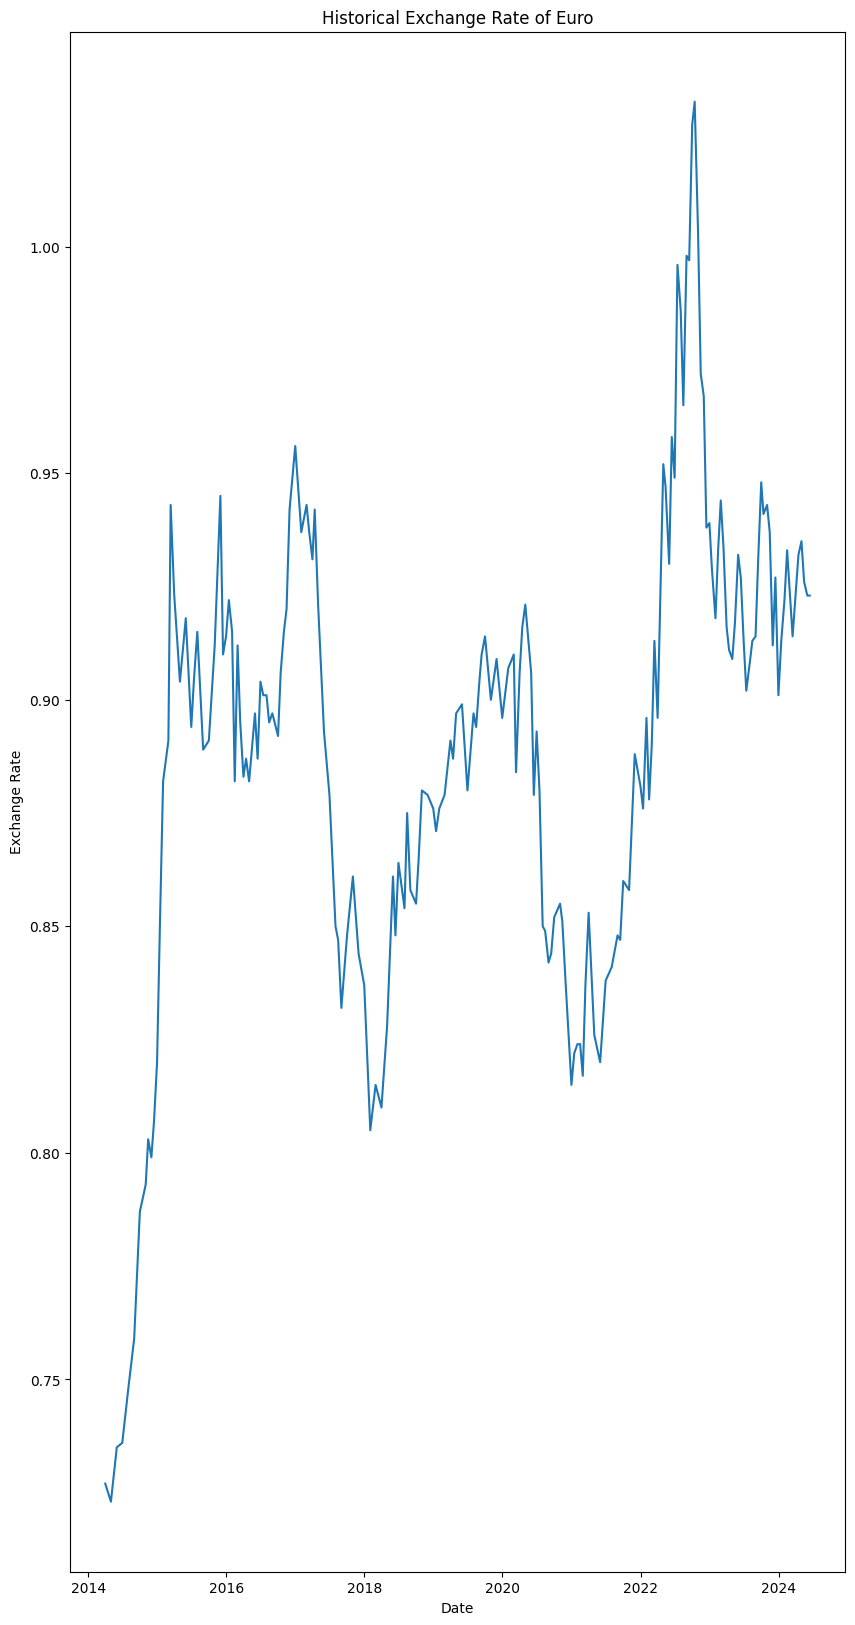

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 20))
sns.lineplot(data=euro_df, x='Date', y='ExchangeRate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Historical Exchange Rate of Euro')
plt.show()
